# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn
plt.style.use("seaborn-v0_8-paper")
import numpy as np

import torch
from sklearn import datasets, decomposition

In [3]:
from polcanet import PolcaNet, LinearDecoder
from polcanet.example_aencoders import autoencoder_factory, StandardScalerTorch, MinMaxScalerTorch

In [4]:
from polcanet.polcanet_reports import analyze_latent_space, show_correlation_matrix, plot_scatter_corr_matrix, plot_stdev_pct, \
    plot_cumsum_variance, analyze_latent_feature_importance, analyze_reconstruction_error, orthogonality_test_analysis, \
    variance_test_analysis, linearity_tests_analysis

In [5]:
np.random.seed(5)

In [6]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

### Load dataset

In [7]:
digits = datasets.load_digits()
X = digits.data / 255
y = digits.target
X.shape,X[0].shape

((1797, 64), (64,))

### Fit standard sklearn PCA

In [8]:
pca = decomposition.PCA(n_components=8)
pca.fit(X)
Xpca = pca.transform(X)
pca.explained_variance_ratio_

array([0.14890594, 0.13618771, 0.11794594, 0.08409979, 0.05782415,
       0.0491691 , 0.04315987, 0.03661373])

### Fit POLCANet

In [109]:
ae_input = X
act_fn = torch.nn.SiLU
input_dim = (ae_input.shape[1],)
latent_dim = 8  # Hey! ... let the kids alone!

encoder = autoencoder_factory(
    input_dim=input_dim,
    latent_dim=latent_dim,
    hidden_dim=1024,
    num_layers=5,
    autoencoder_type="dense",
    act_fn=act_fn,
)

decoder = LinearDecoder(latent_dim=latent_dim,
                             input_dim=input_dim, 
                             hidden_dim=1024, 
                             num_layers=2)


model = PolcaNet(
    encoder=encoder,
    decoder=decoder,
    latent_dim = latent_dim,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cuda",
    # scaler = MinMaxScalerTorch(),
)
model

PolcaNet(
  (encoder): DenseAutoEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=64, out_features=1024, bias=True)
      (1): SiLU()
      (2): ResNet(
        (module): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (4): SiLU()
      (5): ResNet(
        (module): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (6): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (7): SiLU()
      (8): ResNet(
        (module): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (9): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (10): SiLU()
      (11): ResNet(
        (module): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (12): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (13): SiLU()
      (14): Linear(in_features=1024, out_features=8, bias=True)
    )
  )
  (decoder): LinearDecoder(
    (dec

In [110]:
model.to("cuda")
model.train_model(data=X, batch_size= 512, num_epochs=10000, report_freq=100, lr=1e-3)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
Total Loss: 0.06421
Reconstruction Loss: 0.0001327
Orthogonality Loss: 0.4647
Center of Mass Loss: 0.01
Variance Distribution Loss: 0.007604


In [111]:
model.train_model(data=X, batch_size= 512, num_epochs=10000, report_freq=100, lr=1e-4)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
Total Loss: 0.01799
Reconstruction Loss: 0.0001299
Orthogonality Loss: 0.00172
Center of Mass Loss: 0.009986
Variance Distribution Loss: 0.007707


In [112]:
model.train_model(data=X, batch_size= 512, num_epochs=10000, report_freq=100, lr=1e-5)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
Total Loss: 0.01794
Reconstruction Loss: 0.000116
Orthogonality Loss: 0.001993
Center of Mass Loss: 0.009959
Variance Distribution Loss: 0.007662


## Evaluate results

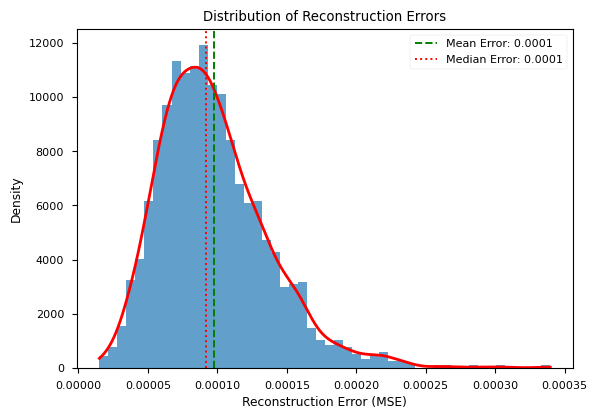

Mean Reconstruction Error: 0.0001
Median Reconstruction Error: 0.0001
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0003


In [86]:
analyze_reconstruction_error(model, X)

In [87]:
latents, reconstructed = model.predict(X)

In [88]:
analyze_latent_space(model, latents=latents)


           Latent Space Analysis Report           

1. General Information
------------------------------
Number of latent components: 16
Total variance in latent space: 806.6203

2. Variance Analysis
------------------------------
Metric                           Value
-----------------------------  -------
First component                 0.5203
First 5 components              1
Components for 95% variance     3
Variance Concentration Metric   0.9609

Variance Concentration Interpretation:
Excellent concentration of variance in earlier dimensions.

3. Orthogonality Analysis
------------------------------
Metric                                 Value
-----------------------------------  -------
Mean absolute off-diagonal            0.0149
Median absolute off-diagonal          0.0017
Max absolute off-diagonal             0.8636
Proportion of |Orthogonality| > 0.1   0.025
Orthogonality Success Metric          0.9851

Orthogonality Interpretation:
Excellent orthogonality of features.

4. 


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: 0.0030
    - Max cosine similarity: 0.0548
    - Min cosine similarity: -0.0537
    


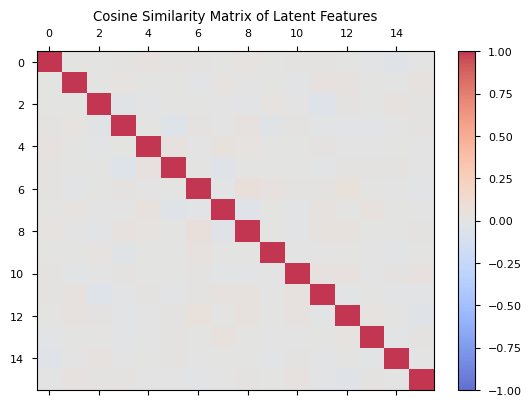

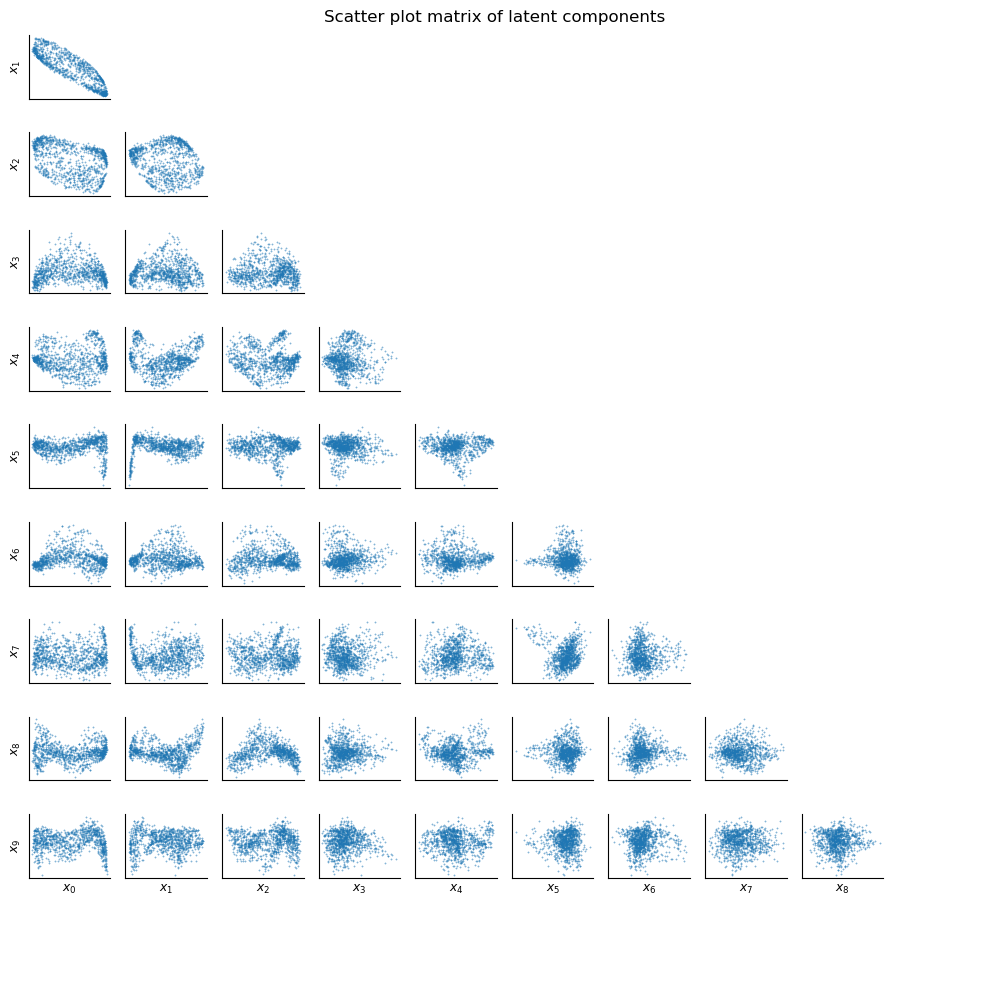

In [89]:
orthogonality_test_analysis(model, X)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.6236
    - Variance fit to exponential distribution (sum of squared differences):
     0.0255
    


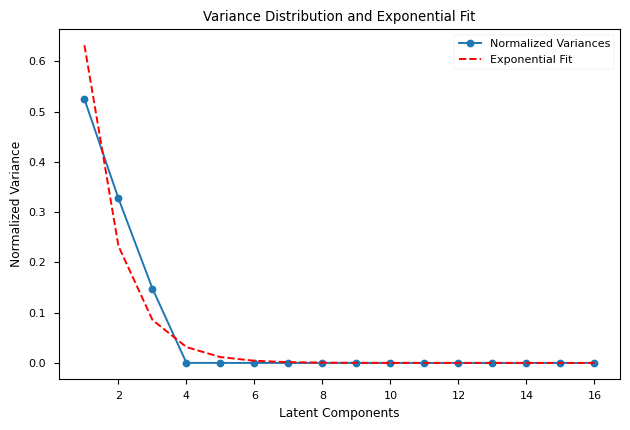

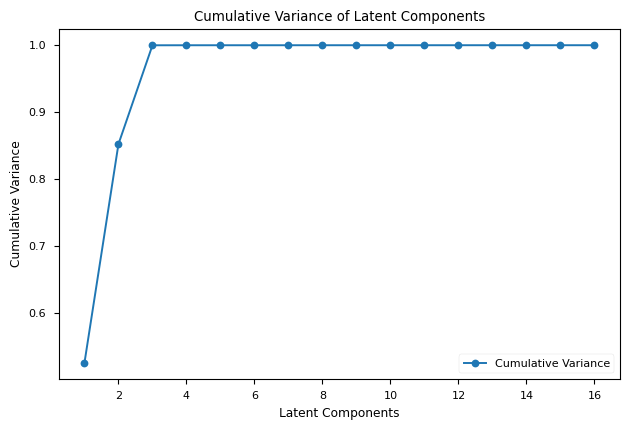

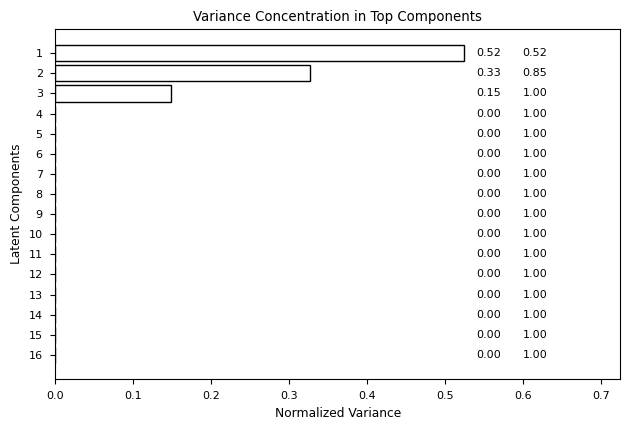

In [90]:
variance_test_analysis(model, X)


    Linearity Tests Analysis

    This report analyzes the linearity properties of the autoencoder. We used a sample size of
    100 randomly selected data points for the analysis.

    The linearity properties of the features are assessed through two tests: additive property
    and homogeneity property. The results are summarized below:

    1. Additive Property:
    ---------------------
    The additive property is tested to verify if:

    f(z_x + z_y) = f(z_x) + f(z_y)

    The differences between the left-hand side and the right-hand side of the equation are
    summarized below:

    - Mean difference: 0.0192
    - Max difference: 0.0474
    - Min difference: 0.0000

    2. Homogeneity Property (Scalar alpha):
    ---------------------------------------
    The homogeneity property is tested to verify if:

    f(a.z_x) = a.f(z_x_)

    The differences between the left-hand side and the right-hand side of the equation are
    summarized below:

    - Mean difference: 0.0010
   

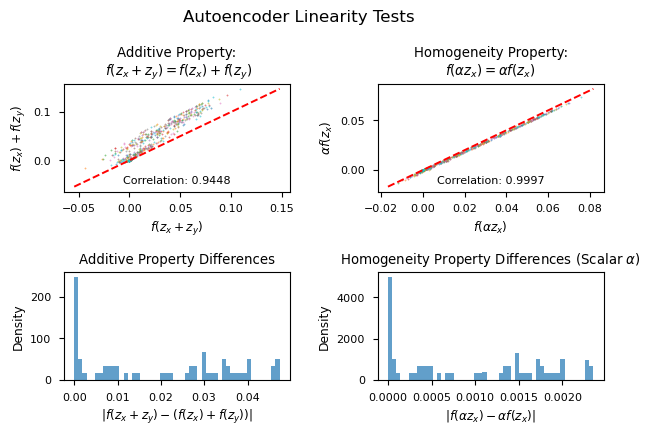

In [91]:
linearity_tests_analysis(model, X)

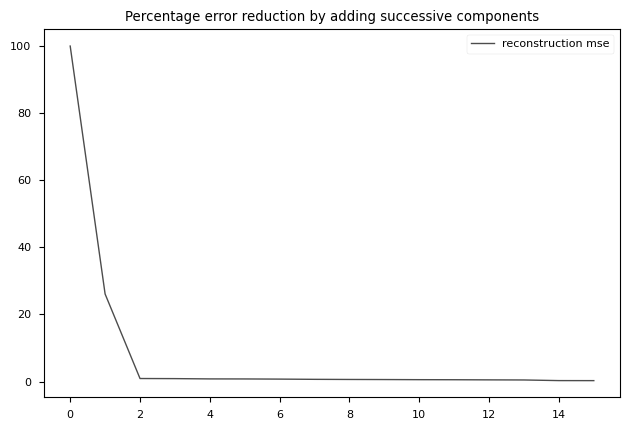

In [92]:
plot_cumsum_variance(model,X)

## Polca Net vs. PCA

In [93]:
def plot2d_analysis(X, y, title, legend=True):
    fig = plt.figure(1, figsize=(5, 5))
    ax = fig.add_subplot(111)

    for label in range(10):
        ax.scatter(X[y == label, 0], X[y == label, 1], label=label)
        ax.set_xlabel("component: 0")
        ax.set_ylabel("component 1")        
    if legend:
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.show()
    return fig, ax

In [94]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    _,_ = plot2d_analysis(Xpca, y, title="PCA transform", legend=True)
with o2:
    _,_ = plot2d_analysis(latents, y, title="POLCA-Net latent")
layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

In [95]:
o1 = widgets.Output()
o2 = widgets.Output()
o3 = widgets.Output()
o4 = widgets.Output()

with o1:
    fig1, ax1 = plot2d_analysis(X, y, "Original data two first componets", legend=False)

with o2:
    latents, reconstructed = model.predict(X)
    fig2, ax2 = plot2d_analysis(np.round(reconstructed, 1), y, title="Reconstructed with POLCA all componets", legend=False)

with o3:
    latents, reconstructed = model.predict(X)
    fig3, ax3 = plot2d_analysis(np.round(reconstructed, 1), y, title="Reconstructed with POLCA two componets", legend=False)

with o4:
    fig4, ax4 = plot2d_analysis(np.round(pca.inverse_transform(Xpca),1), y, "Reconstructed with PCA two componets", legend=False)
    


layout = widgets.Layout(grid_template_columns="repeat(2, 450px)")
accordion = widgets.GridBox(children=[o1, o2, o3, o4], layout=layout)
display(accordion)

GridBox(children=(Output(), Output(), Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 450p…

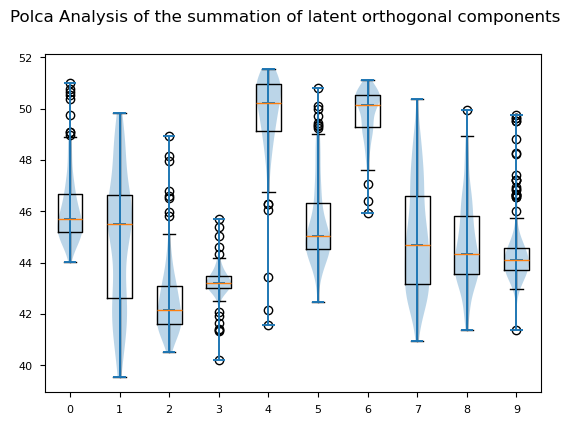

In [96]:
latents, reconstructed = model.predict(X)
vectors = []
labels = [str(i) for i in range(10)]
for c, label in enumerate(labels):
    vectors.append(np.sum(latents[y == c, :], axis=1))


plt.boxplot(vectors, tick_labels=labels)
plt.violinplot(vectors, showmeans=False, showmedians=True)
plt.suptitle("Polca Analysis of the summation of latent orthogonal components")
plt.show()

In [97]:
import seaborn as sns

o1 = widgets.Output()
o2 = widgets.Output()


with o1:
    scores = model.score(X)
    sns.displot(scores, kde=True)
    plt.title("Last component with clean data")
    plt.show()

with o2:
    scores = model.score(X * (np.random.random(size=X.shape) - 0.5) * 1)
    sns.displot(scores, kde=True)
    plt.title("Last componet with uniform noise in data")
    plt.show()


layout = widgets.Layout(grid_template_columns="repeat(2, 500px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 500px)'))

In [98]:
model.std_metrics

array([20.487171  , 16.410479  , 10.840462  ,  0.19602297,  0.08336201,
        0.06076219,  0.07129836,  0.06353634,  0.05608822,  0.05195779,
        0.04589335,  0.0510515 ,  0.04892892,  0.03747956,  0.04775046,
        0.04346538], dtype=float32)

In [99]:
model.mean_metrics

array([ 3.4826946e+01,  8.2857180e+00,  2.5175261e+00, -6.8924687e-04,
       -9.6331182e-04,  6.3696853e-04,  8.5641275e-04, -8.9248506e-06,
        6.3027965e-04, -5.6218822e-04,  6.2253472e-04,  9.9046296e-04,
        8.1320730e-04,  4.2798897e-04, -1.3836927e-03, -3.6607235e-04],
      dtype=float32)

## Test Classification with two components on PCA vs POLCA Net

In [100]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, minmax_scale
import pandas as pd
from scipy.stats import ttest_rel


In [101]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [102]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_train_pca.shape, X_test_pca.shape

((1257, 8), (540, 8))

In [103]:
# Transform the data using POLCA-Net
#X_train_polca = model.predict(X_train,np.array([1, 1, 0, 0]))[0][:,:2]
X_train_polca = model.predict(X_train)[0][:,:8]
#X_test_polca = model.predict(X_test, np.array([1, 1, 0, 0]))[0][:,:2]
X_test_polca = model.predict(X_test)[0][:,:8]
X_train_polca.shape, X_test_polca.shape

((1257, 8), (540, 8))

In [104]:
# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Linear SVM': SVC(kernel='linear', probability=True),
    'Ridge Classifier': RidgeClassifier(),
    'Perceptron': Perceptron()
}

In [105]:
# Train and evaluate classifiers on both PCA and POLCA-Net transformed datasets
results = []

for name, clf in classifiers.items():
    # Train on PCA
    clf.fit(minmax_scale(X_train_pca), y_train)
    y_pred_pca = clf.predict(minmax_scale(X_test_pca))
    accuracy_pca = accuracy_score(y_test, y_pred_pca)
    report_pca = classification_report(y_test, y_pred_pca, output_dict=True)
    cm_pca = confusion_matrix(y_test, y_pred_pca)
    
    # Train on POLCA-Net
    clf.fit(minmax_scale(X_train_polca), y_train)
    y_pred_polca = clf.predict(minmax_scale(X_test_polca))
    accuracy_polca = accuracy_score(y_test, y_pred_polca)
    report_polca = classification_report(y_test, y_pred_polca, output_dict=True)
    cm_polca = confusion_matrix(y_test, y_pred_polca)
    
    # Append results
    results.append({
        'Classifier': name,
        'Transformation': 'PCA',
        'Accuracy': accuracy_pca,
        'Precision': report_pca['weighted avg']['precision'],
        'Recall': report_pca['weighted avg']['recall'],
        'F1-Score': report_pca['weighted avg']['f1-score'],
        'Confusion Matrix': cm_pca
    })
    
    results.append({
        'Classifier': name,
        'Transformation': 'POLCA-Net',
        'Accuracy': accuracy_polca,
        'Precision': report_polca['weighted avg']['precision'],
        'Recall': report_polca['weighted avg']['recall'],
        'F1-Score': report_polca['weighted avg']['f1-score'],
        'Confusion Matrix': cm_polca
    })

In [106]:
# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Display the main metrics table
main_metrics_df = results_df.drop(columns=['Confusion Matrix'])
main_metrics_df

,Classifier,Transformation,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,PCA,0.851852,0.857367,0.851852,0.852770
1,Logistic Regression,POLCA-Net,0.764815,0.762204,0.764815,0.753721
2,Gaussian Naive Bayes,PCA,0.861111,0.866776,0.861111,0.862104
3,Gaussian Naive Bayes,POLCA-Net,0.724074,0.725959,0.724074,0.717279
4,Linear SVM,PCA,0.905556,0.909331,0.905556,0.906228
5,Linear SVM,POLCA-Net,0.824074,0.821425,0.824074,0.820668
6,Ridge Classifier,PCA,0.812963,0.817767,0.812963,0.808361
7,Ridge Classifier,POLCA-Net,0.675926,0.679100,0.675926,0.652812
8,Perceptron,PCA,0.759259,0.860092,0.759259,0.733223
9,Perceptron,POLCA-Net,0.679630,0.765348,0.679630,0.641622


In [107]:
# Statistical test: Paired t-test for accuracies
pca_accuracies = results_df[results_df['Transformation'] == 'PCA']['F1-Score']
polca_accuracies = results_df[results_df['Transformation'] == 'POLCA-Net']['F1-Score']

t_stat, p_value = ttest_rel(pca_accuracies.values, polca_accuracies.values)

print(f"\nPaired t-test results: t-statistic = {t_stat}, p-value = {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between the PCA and POLCA-Net transformations.")
else:
    print("There is no statistically significant difference between the PCA and POLCA-Net transformations.")



Paired t-test results: t-statistic = 7.955827385877297, p-value = 0.001352064898872246
There is a statistically significant difference between the PCA and POLCA-Net transformations.


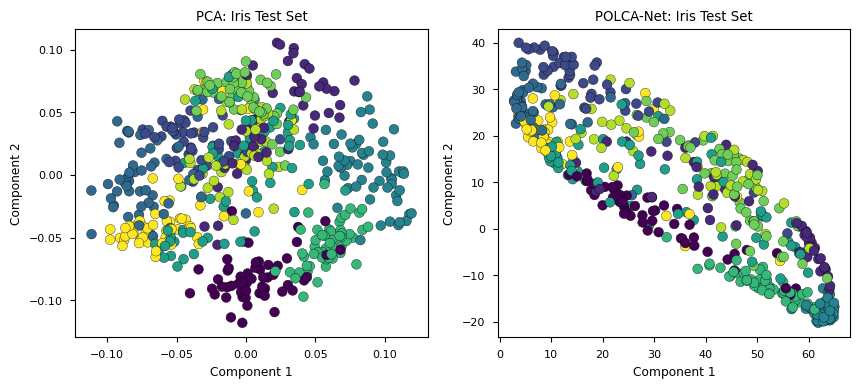

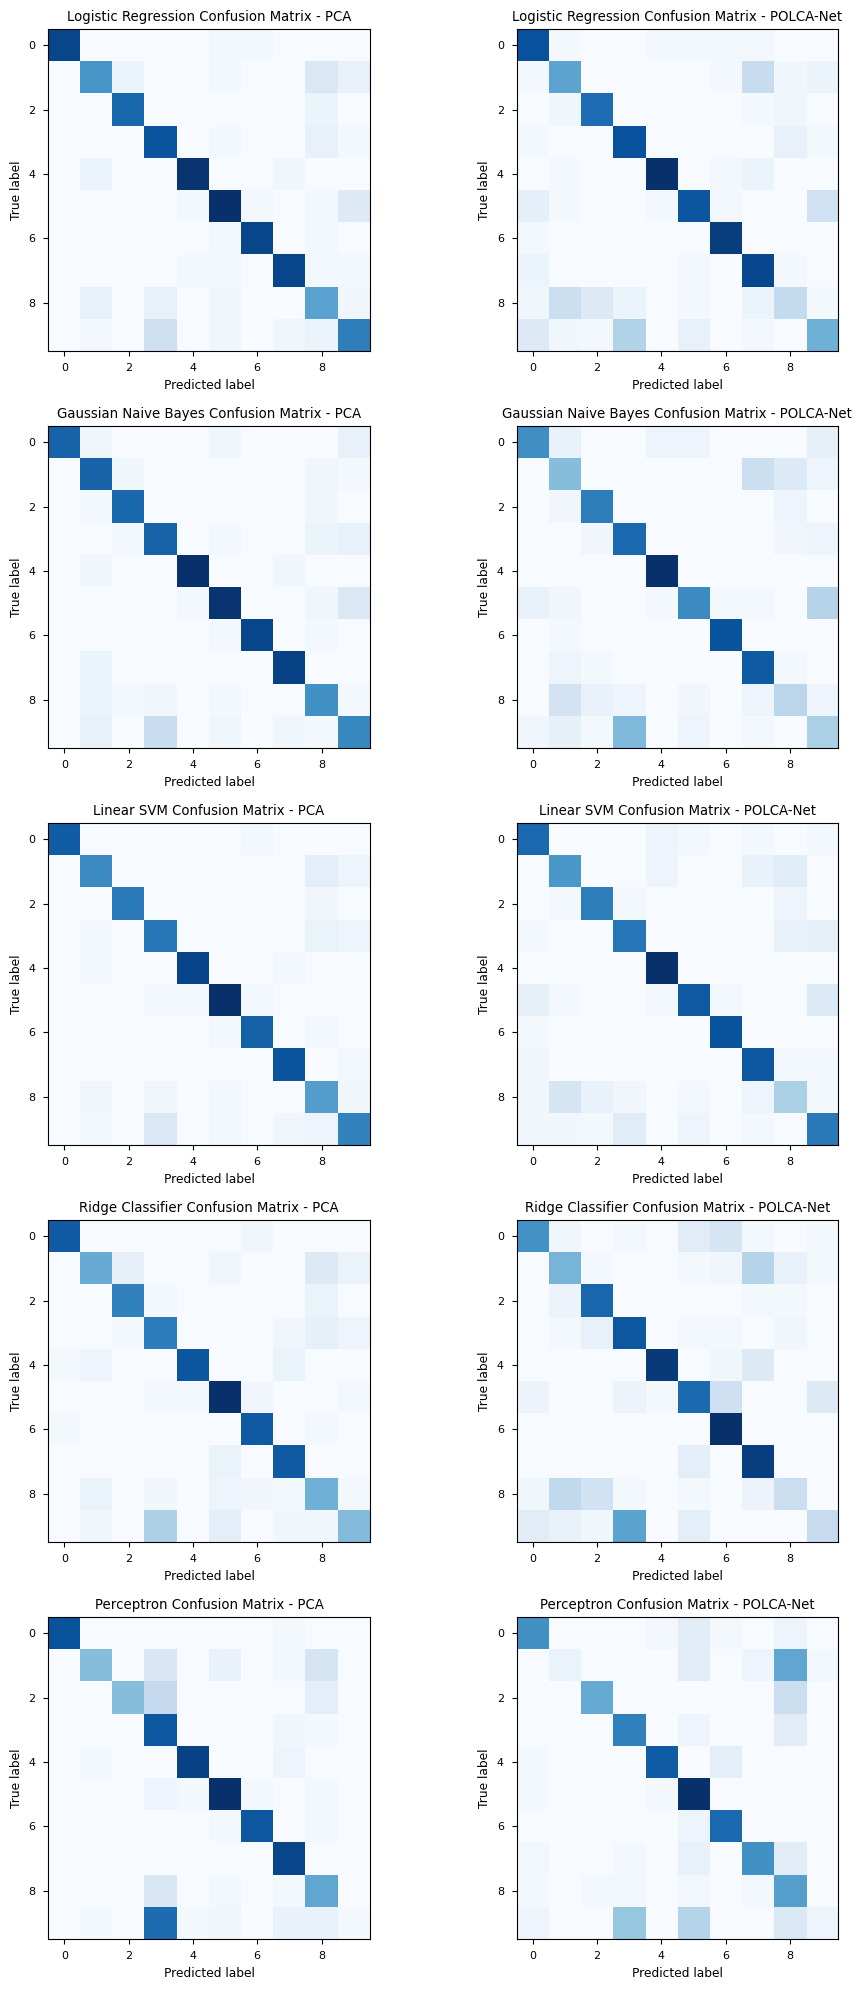

In [108]:
# Plotting the results
plt.figure(figsize=(10, 4))

# Plot PCA
plt.subplot(1, 2, 1)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='viridis', edgecolor='k', s=50)
plt.title('PCA: Iris Test Set')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

# Plot POLCA-Net
plt.subplot(1, 2, 2)
plt.scatter(X_test_polca[:, 0], X_test_polca[:, 1], c=y_test, cmap='viridis', edgecolor='k', s=50)
plt.title('POLCA-Net: Iris Test Set')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.show()

# Plot Confusion Matrices for each classifier
fig, axes = plt.subplots(len(classifiers), 2, figsize=(10, 20))

for i, (name, clf) in enumerate(classifiers.items()):
    # PCA Confusion Matrix
    cm_pca = results_df[(results_df['Classifier'] == name) & (results_df['Transformation'] == 'PCA')]['Confusion Matrix'].values[0]
    axes[i, 0].imshow(cm_pca, interpolation='nearest', cmap=plt.cm.Blues)
    axes[i, 0].set_title(f'{name} Confusion Matrix - PCA')
    axes[i, 0].set_xlabel('Predicted label')
    axes[i, 0].set_ylabel('True label')
    
    # POLCA-Net Confusion Matrix
    cm_polca = results_df[(results_df['Classifier'] == name) & (results_df['Transformation'] == 'POLCA-Net')]['Confusion Matrix'].values[0]
    axes[i, 1].imshow(cm_polca, interpolation='nearest', cmap=plt.cm.Blues)
    axes[i, 1].set_title(f'{name} Confusion Matrix - POLCA-Net')
    axes[i, 1].set_xlabel('Predicted label')
    axes[i, 1].set_ylabel('True label')

plt.tight_layout()
plt.show()